<a href="https://colab.research.google.com/github/findinggeels/projecd2/blob/main/notebooks/train-yolo11-object-detection-on-custom-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO11 Object Detection on a Custom Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Nov 13 20:54:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [3]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.30 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.4/112.6 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [4]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 940, in entrypoint
    model = YOLO(model, task=task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/models/yolo/model.py", line 23, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 145, in __init__
    self._load(model, task=task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 285, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 910, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 815, in torch_safe_load
    file = attempt_downl

**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

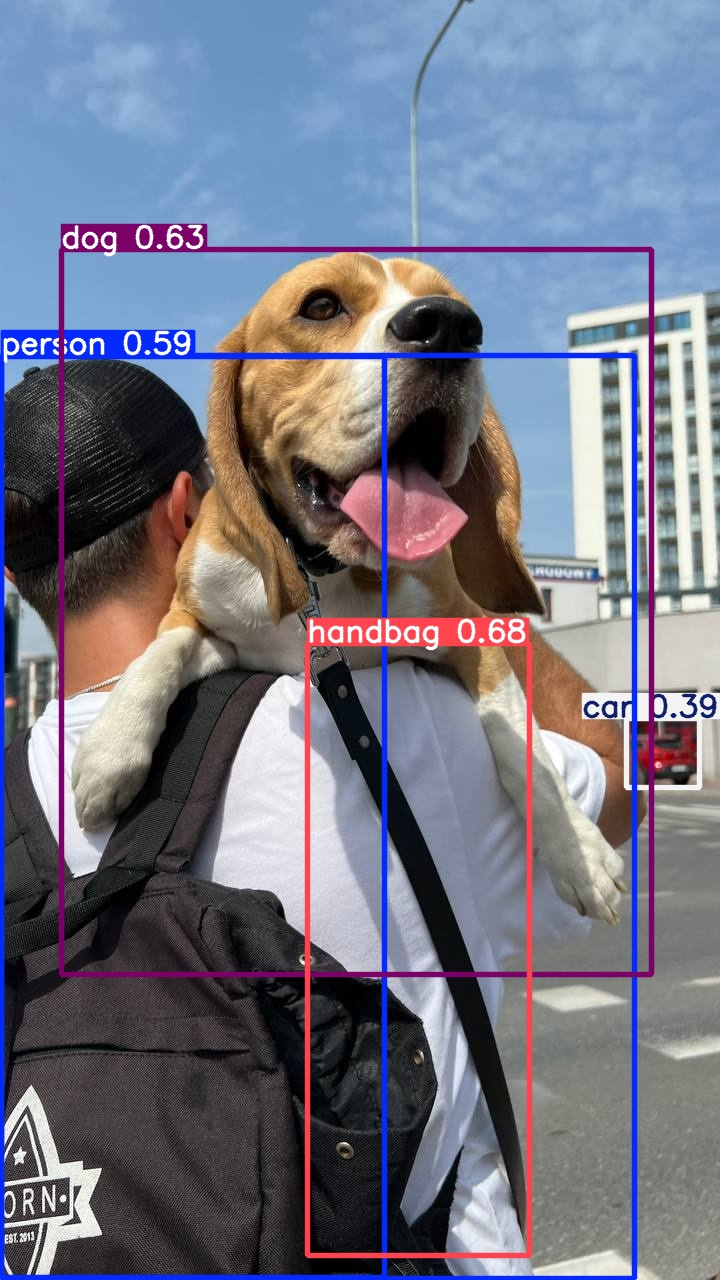

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/predict/dog.jpeg', width=600)

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [5]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://media.roboflow.com/notebooks/examples/dog.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]

100%|██████████| 5.35M/5.35M [00:00<00:00, 208MB/s]



0: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 101.9ms
Speed: 20.7ms preprocess, 101.9ms inference, 1106.9ms postprocess per image at shape (1, 3, 640, 384)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [ ]:
result.boxes.xyxy

tensor([[3.0705e+02, 6.4341e+02, 5.2919e+02, 1.2558e+03],
        [6.1400e+01, 2.4994e+02, 6.5165e+02, 9.7412e+02],
        [1.7803e+00, 3.5551e+02, 6.3404e+02, 1.2788e+03],
        [1.1933e+00, 3.5620e+02, 3.8455e+02, 1.2776e+03],
        [6.2615e+02, 7.1818e+02, 6.9975e+02, 7.8754e+02]], device='cuda:0')

In [ ]:
result.boxes.conf

tensor([0.6832, 0.6284, 0.5941, 0.3923, 0.3875], device='cuda:0')

In [ ]:
result.boxes.cls

tensor([26., 16.,  0.,  0.,  2.], device='cuda:0')

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [ ]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

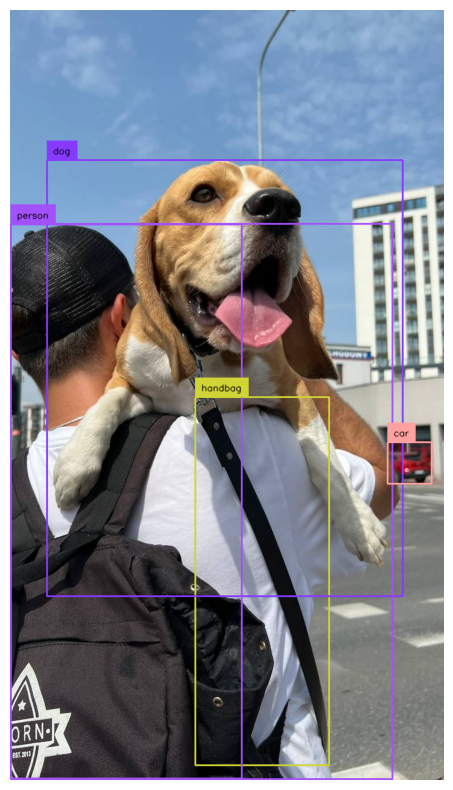

In [ ]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [7]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="xpW58GcpvNe6V3QdU1TA")
project = rf.workspace("geels").project("waste-detect-53nqc")
version = project.version(11)
dataset = version.download("yolov11")


mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to waste-detect-11 in yolov11:: 100%|██████████| 1746/1746 [00:00<00:00, 6992.84it/s]


## Custom Training

In [8]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 478MB/s]
Ultralytics 8.3.30 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/waste-detect-11/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fa

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [9]:
!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png	   val_batch0_pred.jpg
confusion_matrix_normalized.png			    R_curve.png		   val_batch1_labels.jpg
confusion_matrix.png				    results.csv		   val_batch1_pred.jpg
events.out.tfevents.1731531521.6252b9b0b575.2092.0  results.png		   val_batch2_labels.jpg
F1_curve.png					    train_batch0.jpg	   val_batch2_pred.jpg
labels_correlogram.jpg				    train_batch1.jpg	   weights
labels.jpg					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


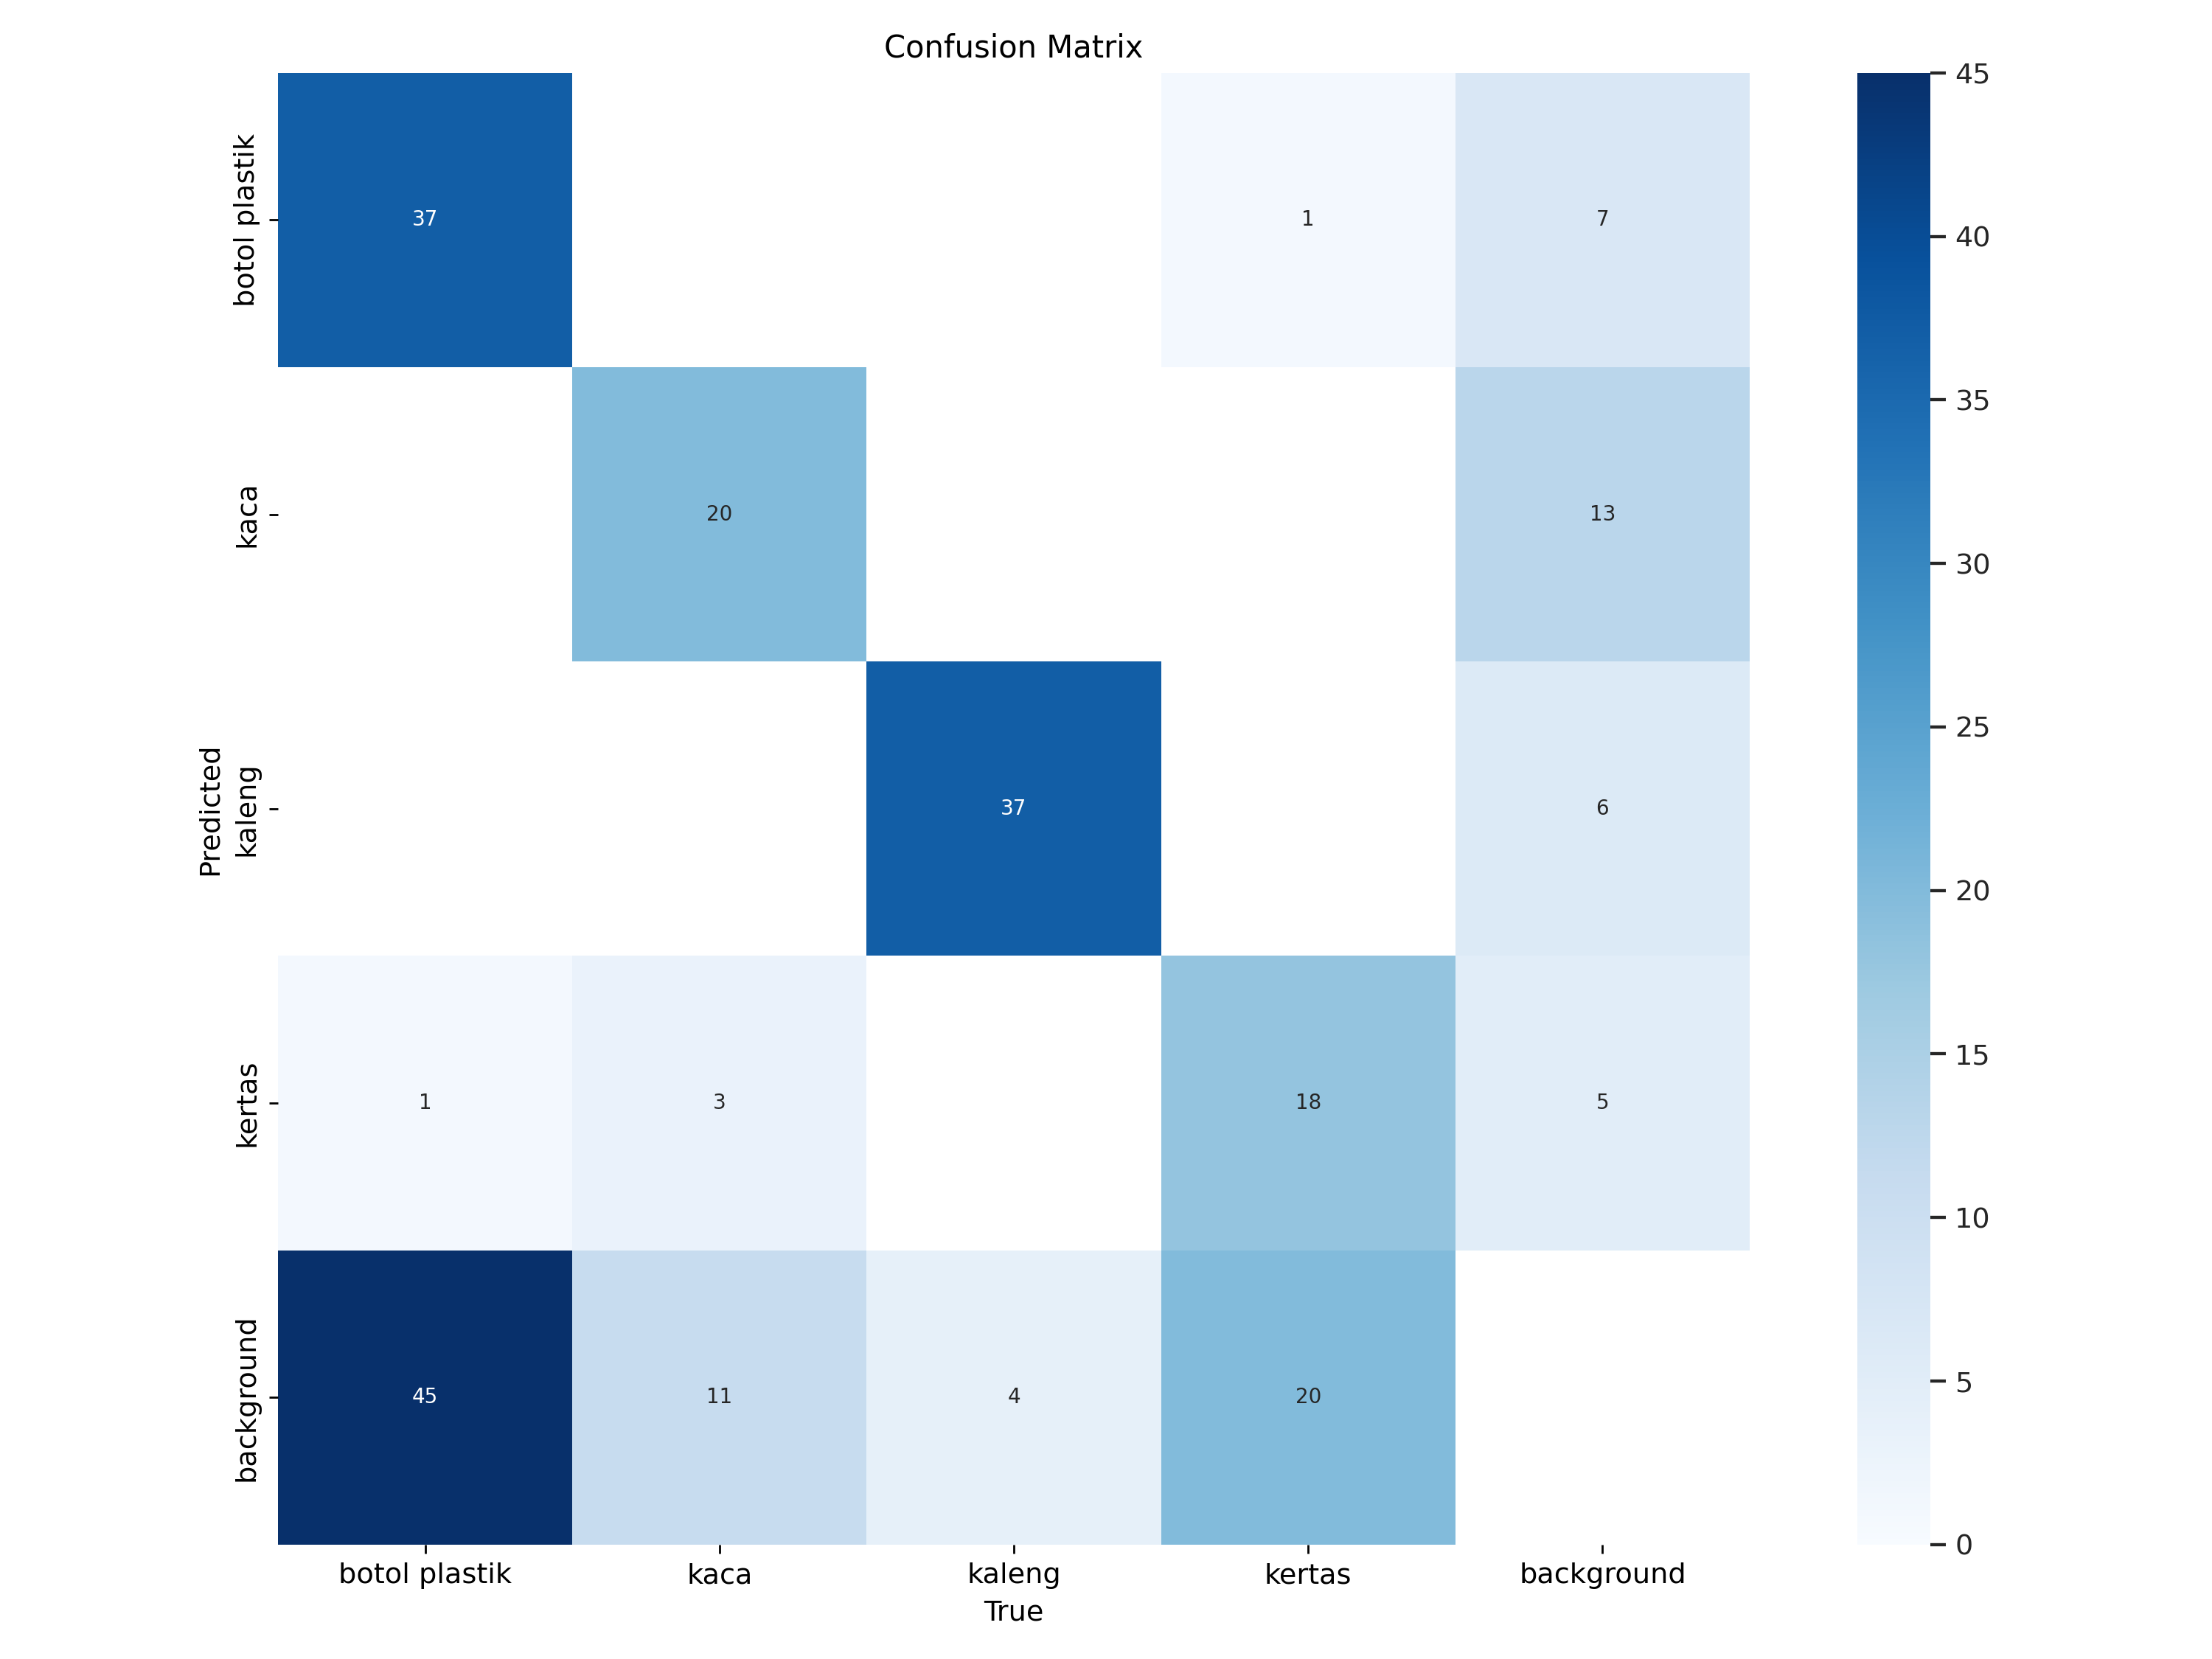

In [10]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

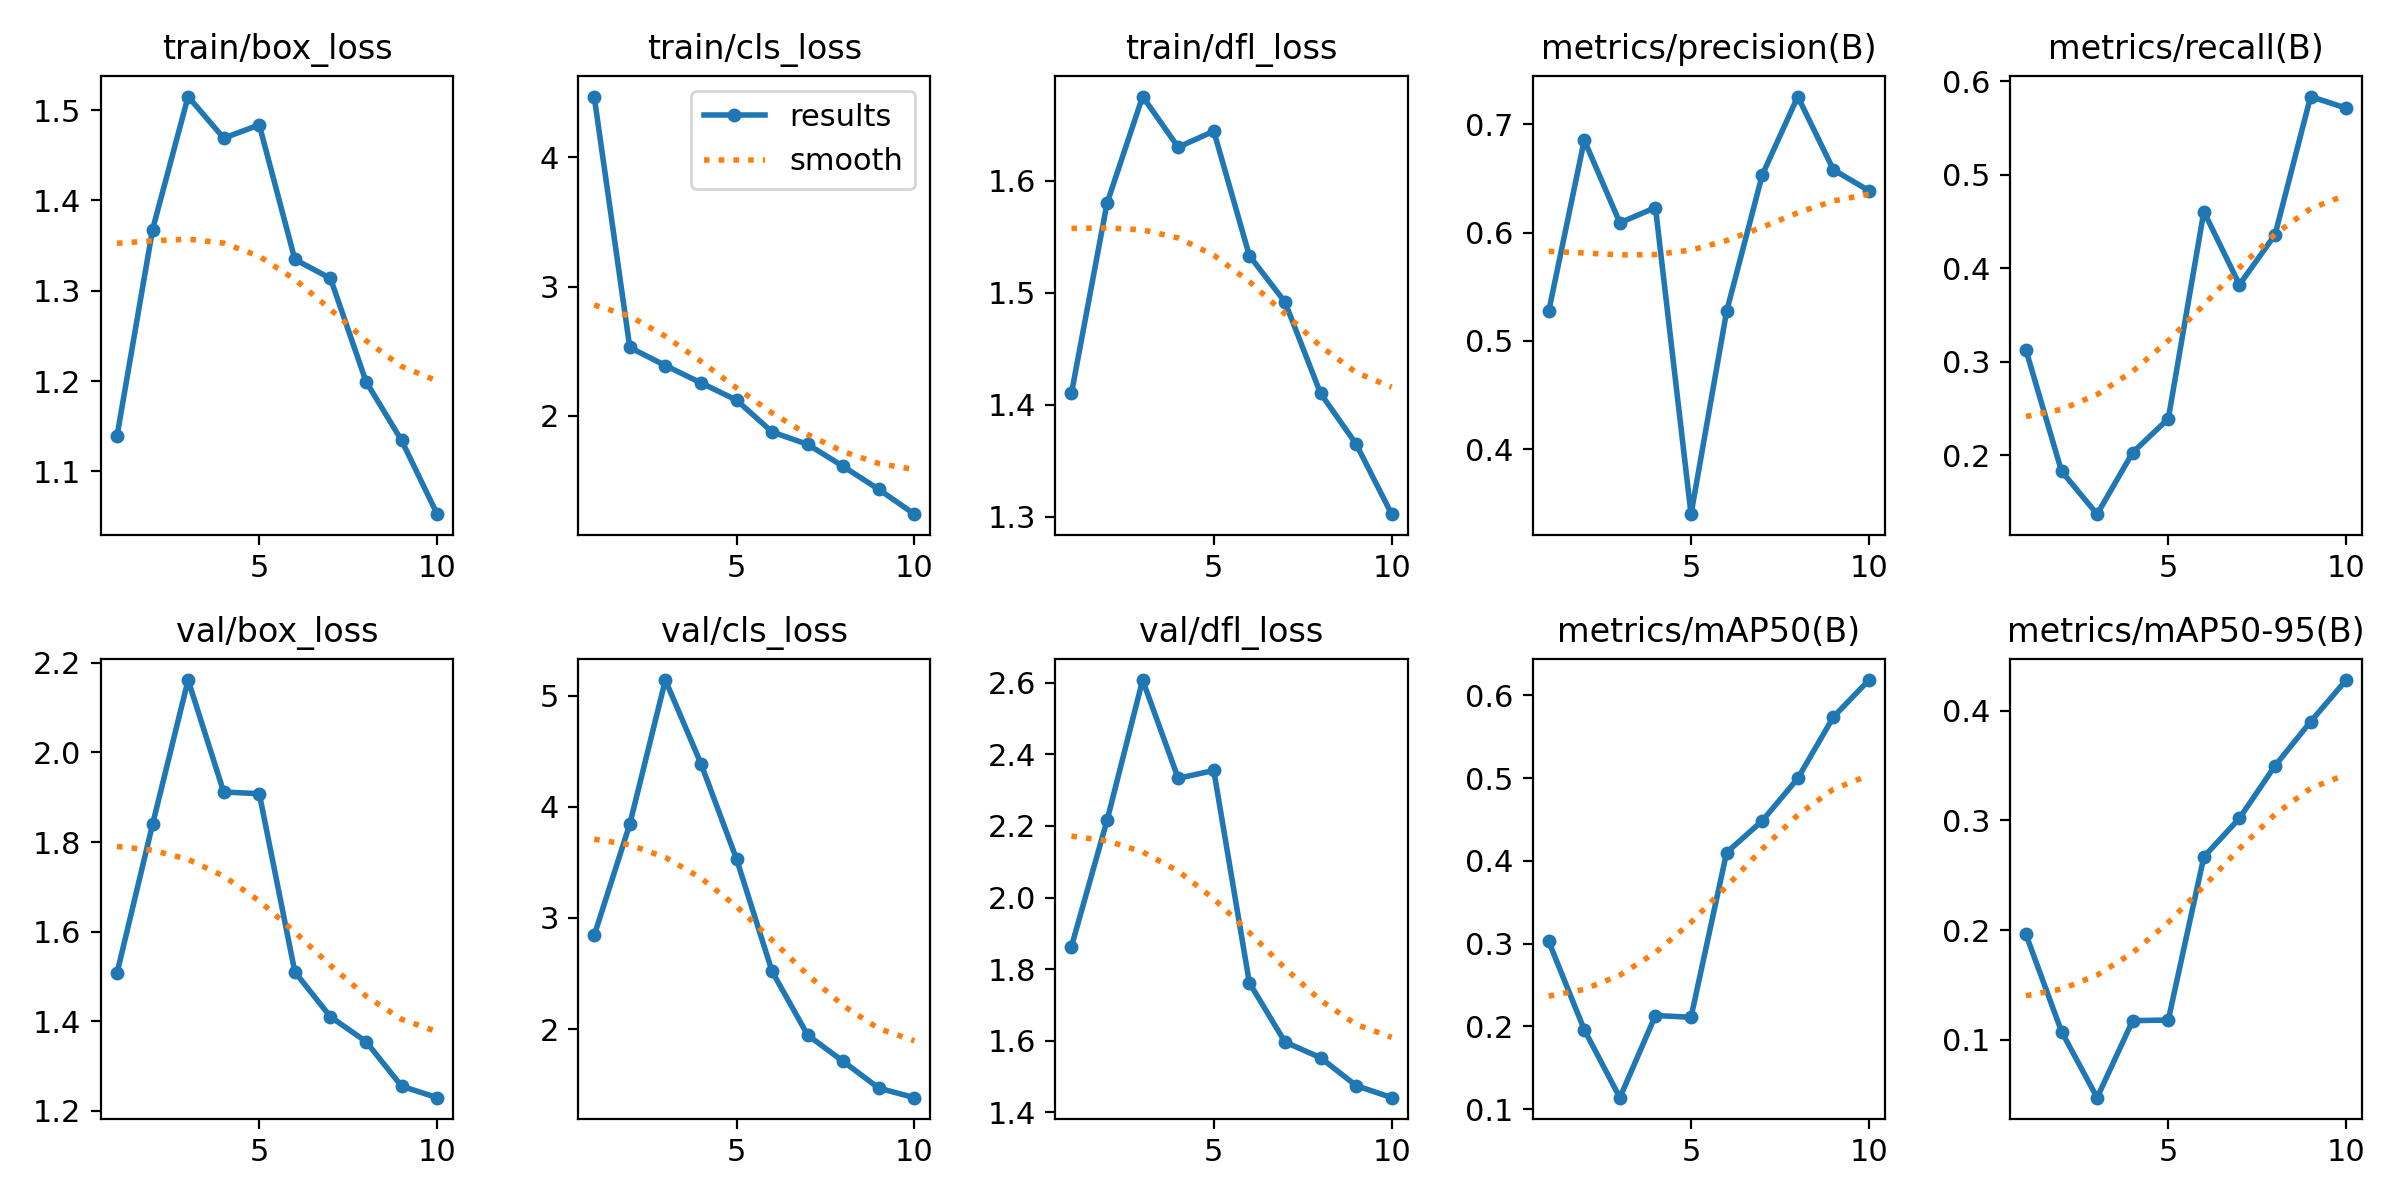

In [11]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

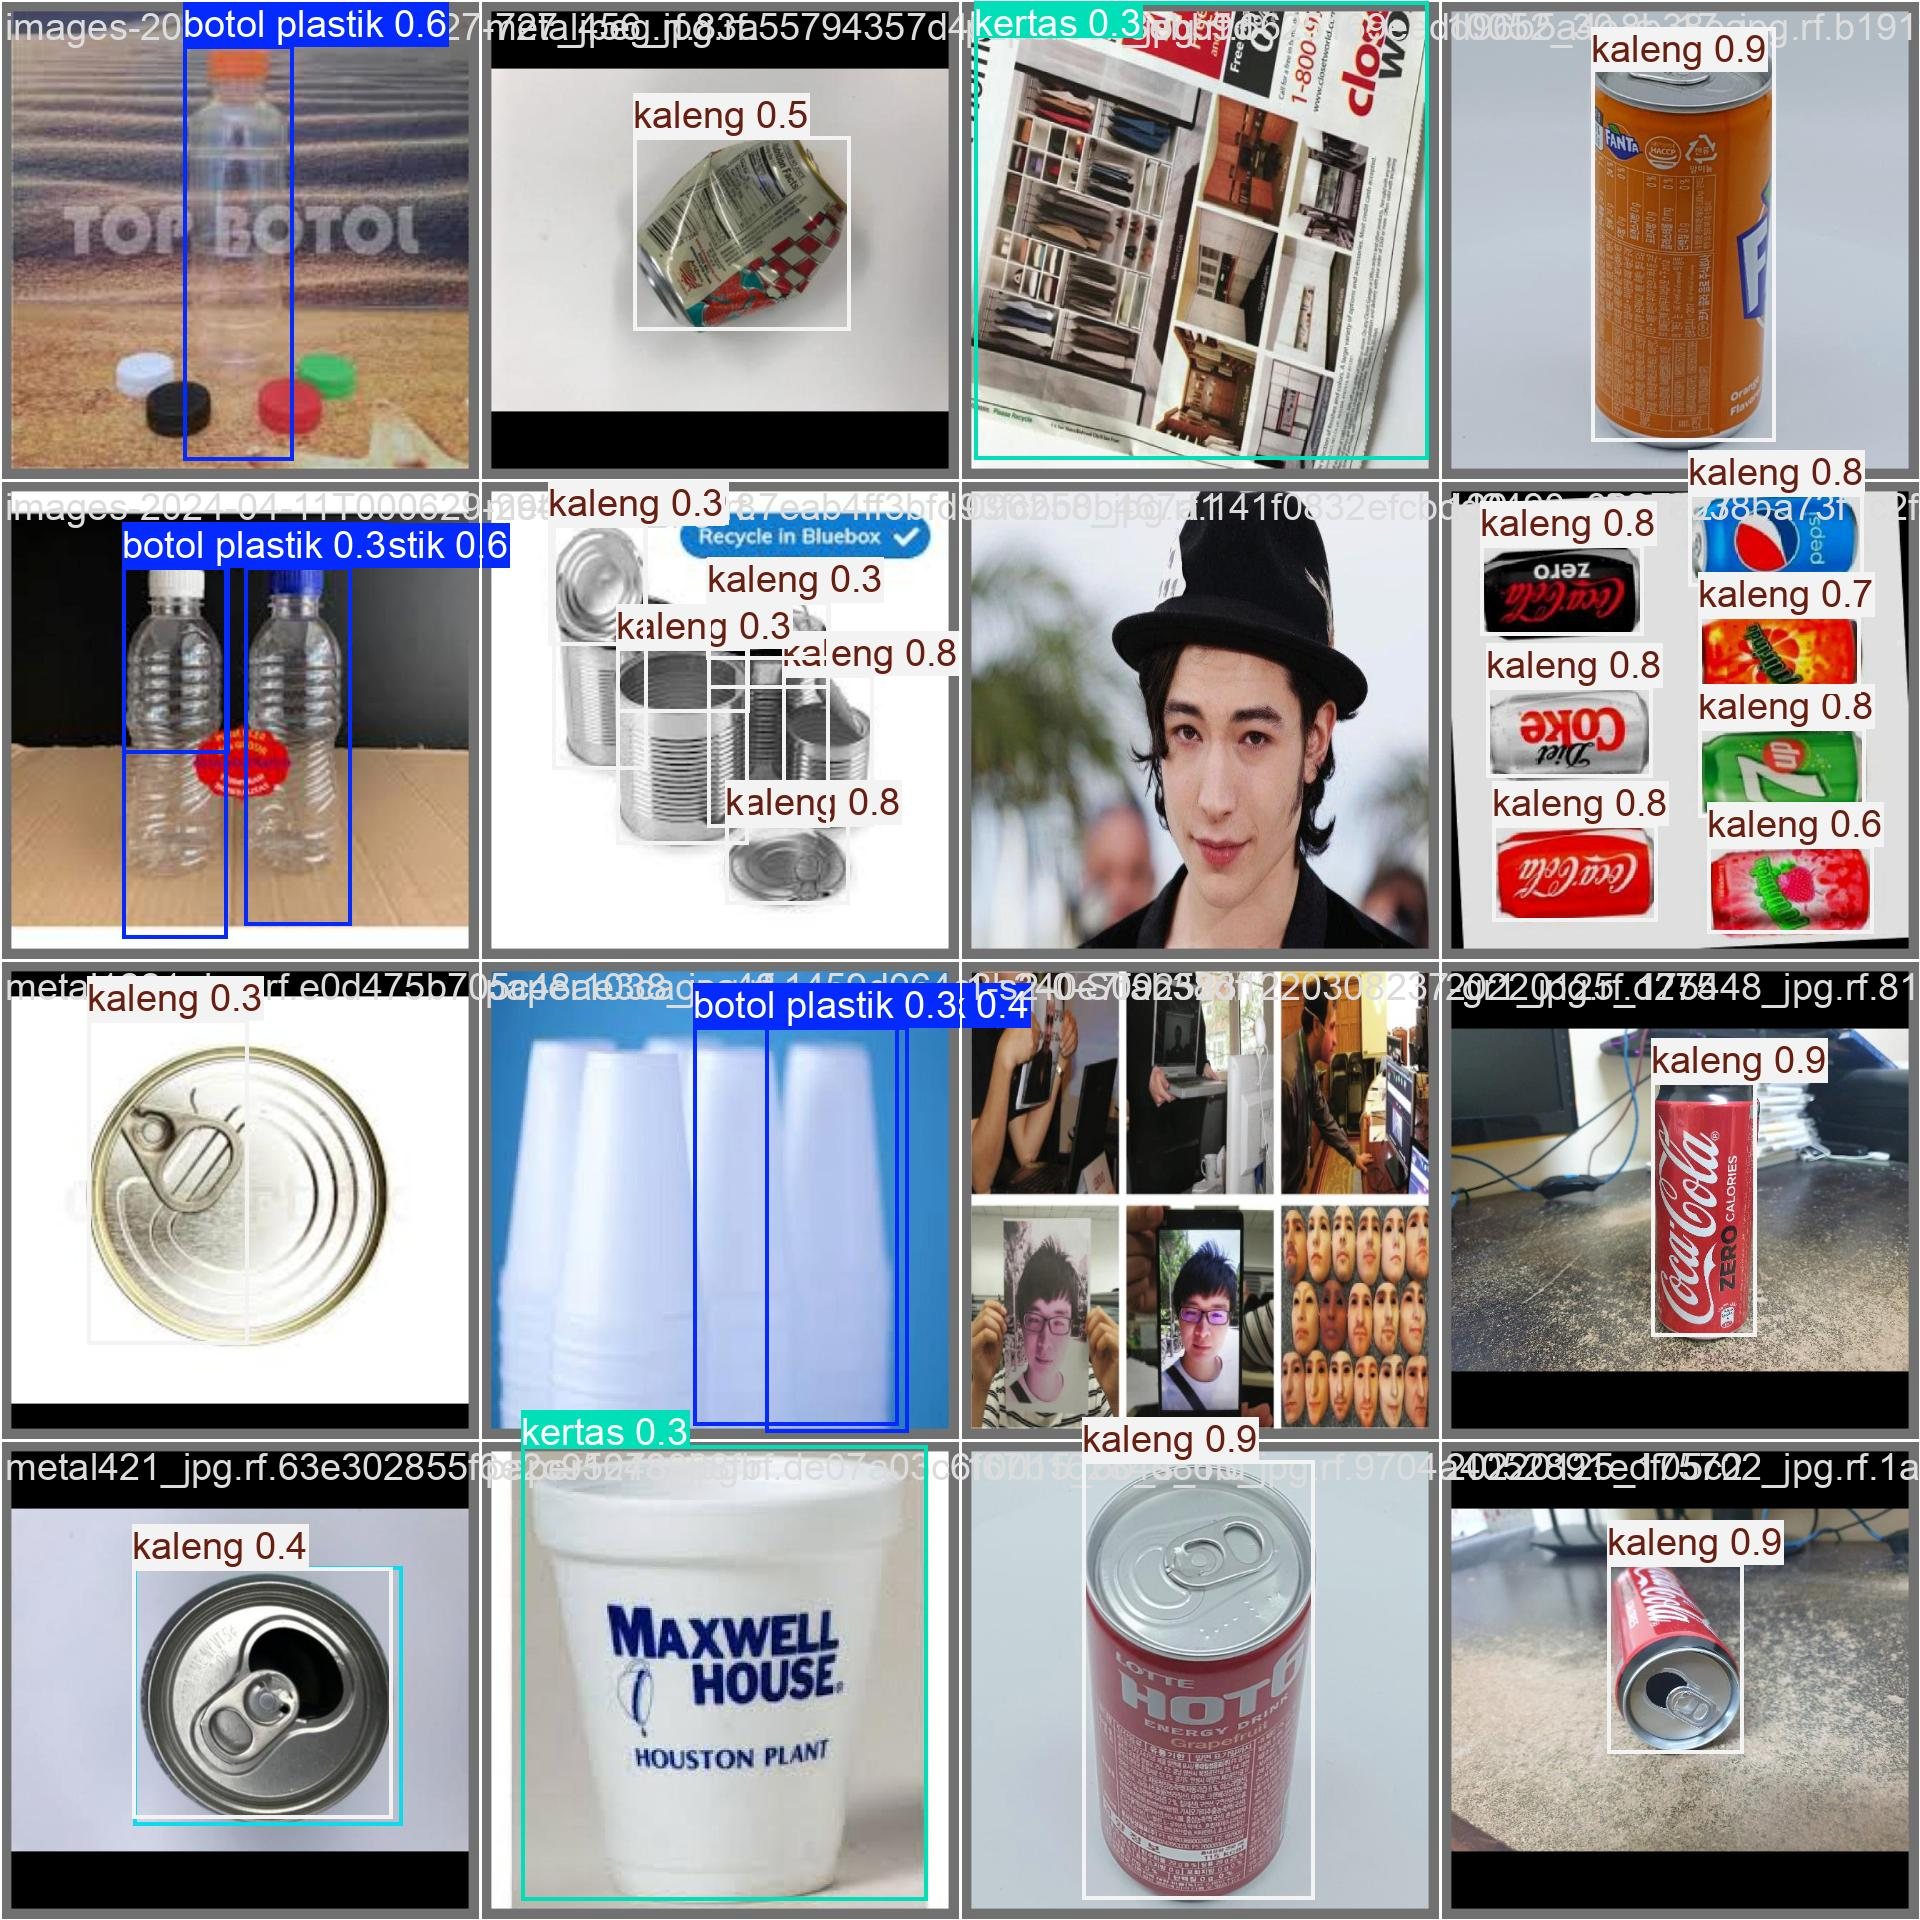

In [12]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [13]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.30 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/waste-detect-11/valid/labels.cache... 94 images, 6 backgrounds, 0 corrupt: 100% 94/94 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 4, len(boxes) = 197. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 6/6 [00:03<00:00,  1.99it/s]
                   all         94        197      0.623      0.595      0.618      0.426
         botol plastik         22         83      0.712      0.417      0.513      0.272
                  kaca         22         34       0.48      0.588      0.586      0.366
                kaleng         22     

## Inference with custom model

In [14]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.30 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs

image 1/94 /content/datasets/waste-detect-11/test/images/-57_jpg.rf.e101a695068ae6e0a22ad0ffa3374ac3.jpg: 640x640 1 kertas, 15.6ms
image 2/94 /content/datasets/waste-detect-11/test/images/-86_jpg.rf.cd5c76f0a59a33ec827f3d5545202360.jpg: 640x640 1 kaleng, 15.6ms
image 3/94 /content/datasets/waste-detect-11/test/images/0217013439_jpg.rf.f953a59033c9775edd2ae83a34061a72.jpg: 640x640 1 botol plastik, 15.5ms
image 4/94 /content/datasets/waste-detect-11/test/images/0217015952_jpg.rf.d0c87e7b3b1fbe85cfe0d233f5e584df.jpg: 640x640 1 botol plastik, 15.5ms
image 5/94 /content/datasets/waste-detect-11/test/images/10019_60_s_1_jpg.rf.eeaca02ad4a1c6d6f700deed8fd345d6.jpg: 640x640 1 kaleng, 15.5ms
image 6/94 /content/datasets/waste-detect-11/test/images/106563_jpg.rf.a382cccd82bcf54f6f650a1902cbe441.jpg: 640x640 (no detections), 15.5ms


**NOTE:** Let's take a look at few results.

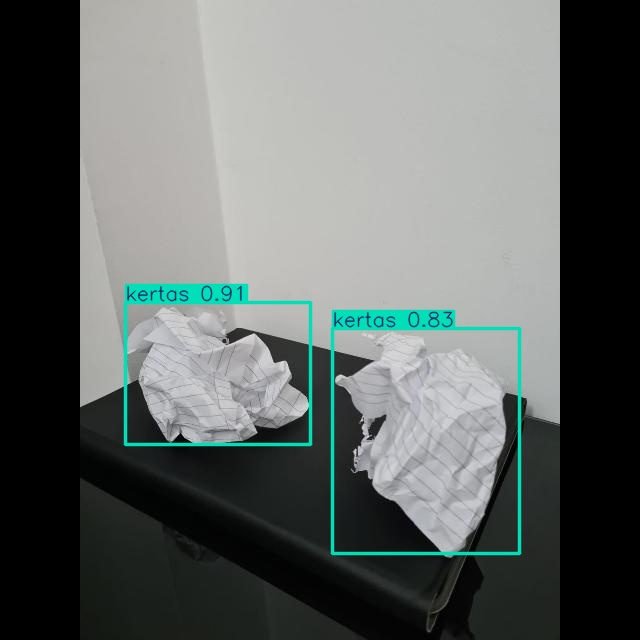

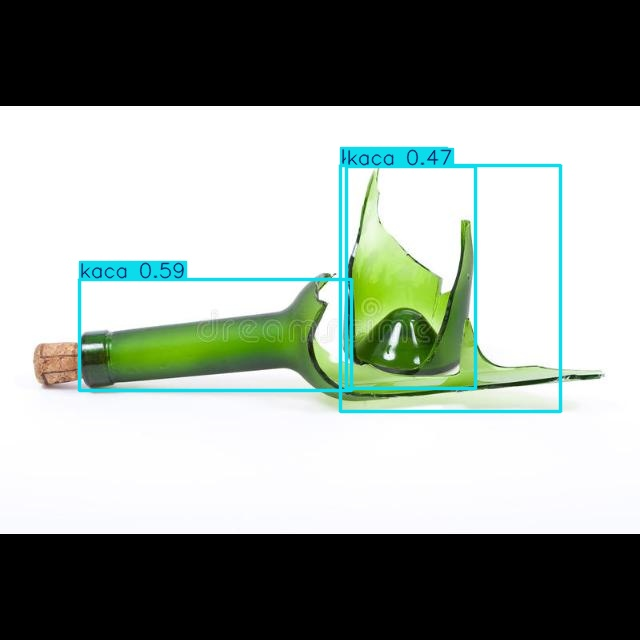

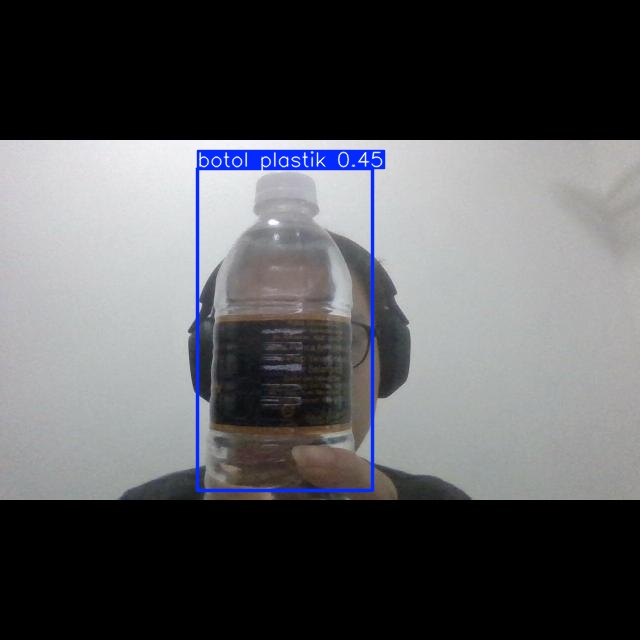

In [15]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [34]:
!ls /content/runs/detect/train/weights/


best.pt  last.pt


In [38]:
!find /content -name "best.pt"


/content/runs/detect/train/weights/best.pt


In [42]:
!chmod 644 /content/runs/detect/train/weights/best.pt


In [43]:
from google.colab import files
files.download("/content/runs/detect/train/weights/best.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
!pip install inference

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.7/804.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.9/891.9 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 25.8 MB/s eta 0:00:00
   ━━━━━

Running inference on metal810_jpg.rf.485d33a02b3aeafde7ca32083319823b.jpg


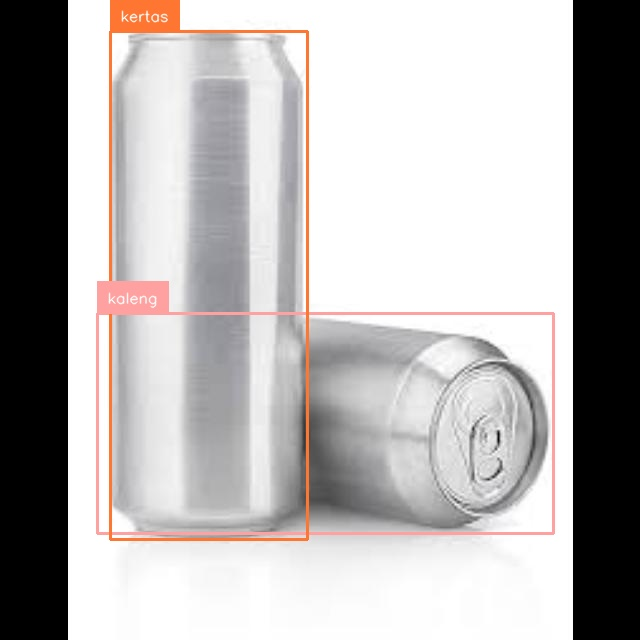

Running inference on metal910_jpg.rf.d622641670ff77614e7dd94b764be94e.jpg


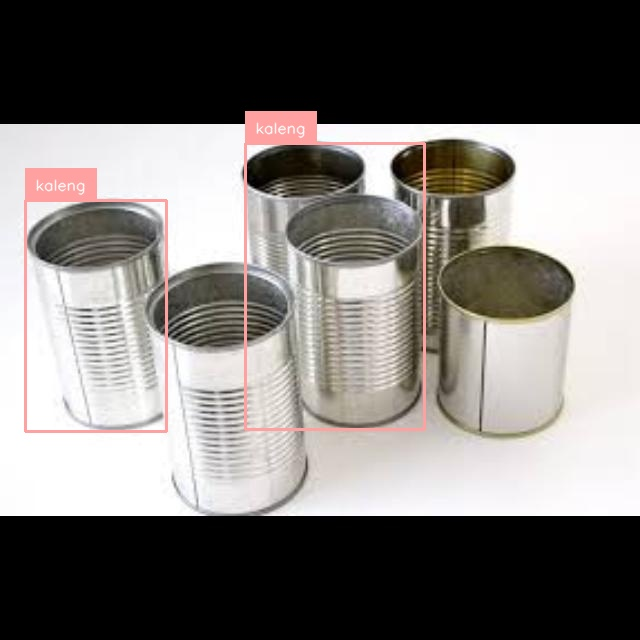

Running inference on broken_glass_bottle-113_jpg.rf.589cf733e5a25d4ebb5a86b61e480a67.jpg


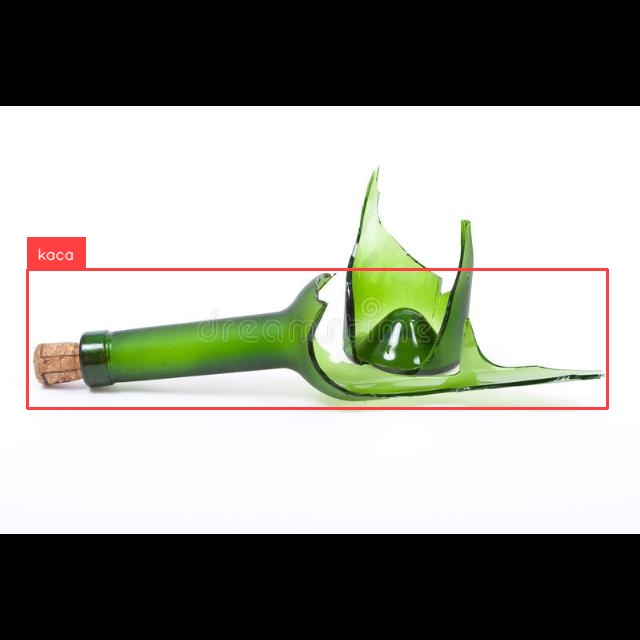

Running inference on WIN_20241105_00_20_33_Pro_jpg.rf.daaee847a0b2c7dafd5aad44b36b4ed7.jpg


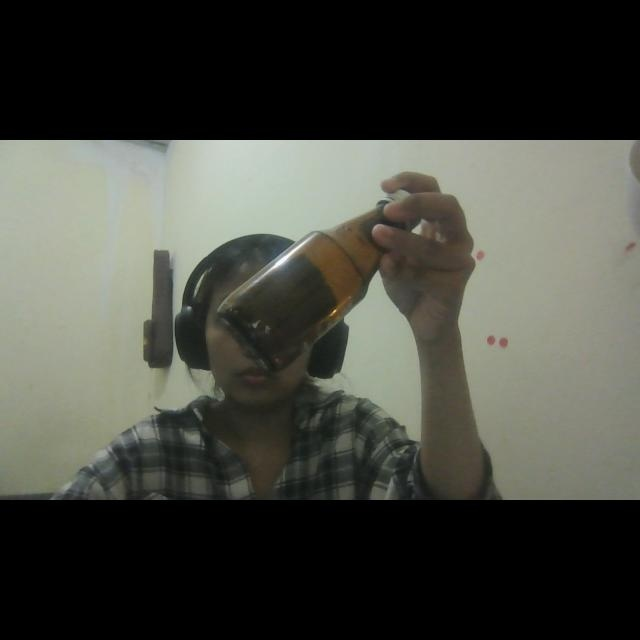

In [45]:
import os, random, cv2
import supervision as sv
import IPython
import inference

# Ensure correct API key setup
api_key = "xpW58GcpvNe6V3QdU1TA"  # Replace with your Roboflow API key
model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, api_key)

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    display_image = IPython.display.Image(data=ret.tobytes())
    IPython.display.display(display_image)


!pip install tensorflowjs


In [46]:
!pip install pyyaml h5py  # Required to save models in HDF5 format.

In [48]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.17.0


In [49]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_labels = train_labels[:1000]
test_labels = test_labels[:1000]

train_images = train_images[:1000].reshape(-1, 28 * 28) / 255.0
test_images = test_images[:1000].reshape(-1, 28 * 28) / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [50]:
# Define a simple sequential model
def create_model():
  model = tf.keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

  return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 407,050 (1.55 MB)

 Trainable params: 407,050 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
checkpoint_path = "training_1/cp.weights.h5" # Since you're only saving weights, you should use the .weights.h5 extension. If you're saving the whole model, you would use the .keras extension instead
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
model.fit(train_images,
          train_labels,
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[cp_callback])  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.6377 - sparse_categorical_accuracy: 0.4871
Epoch 1: saving model to training_1/cp.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 1.6233 - sparse_categorical_accuracy: 0.4924 - val_loss: 0.7050 - val_sparse_categorical_accuracy: 0.7790
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4511 - sparse_categorical_accuracy: 0.8728   
Epoch 2: saving model to training_1/cp.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4499 - sparse_categorical_accuracy: 0.8732 - val_loss: 0.5257 - val_sparse_categorical_accuracy: 0.8340
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2452 - sparse_categorical_accuracy: 0.9473  
Epoch 3: saving model to training_1/cp.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2464 - sparse_categorical_accuracy: 0.9470 - val_loss: 0.4859 - val_sparse_categorical_accuracy: 0.8530
Epoch 4/10
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2067 - sparse_c

In [53]:
os.listdir(checkpoint_dir)

['cp.weights.h5']

In [54]:
# Create a basic model instance
model = create_model()

# Evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 1s - 23ms/step - loss: 2.3467 - sparse_categorical_accuracy: 0.1330
Untrained model, accuracy: 13.30%


In [55]:
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 0s - 2ms/step - loss: 0.4056 - sparse_categorical_accuracy: 0.8760
Restored model, accuracy: 87.60%


In [56]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-{epoch:04d}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.mkdir(checkpoint_dir)

batch_size = 32

# Calculate the number of batches per epoch
import math
n_batches = len(train_images) / batch_size
n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5*n_batches)

# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model.fit(train_images,
          train_labels,
          epochs=50,
          batch_size=batch_size,
          callbacks=[cp_callback],
          validation_data=(test_images, test_labels),
          verbose=0)


Epoch 5: saving model to training_2/cp-0005.weights.h5

Epoch 10: saving model to training_2/cp-0010.weights.h5

Epoch 15: saving model to training_2/cp-0015.weights.h5

Epoch 20: saving model to training_2/cp-0020.weights.h5

Epoch 25: saving model to training_2/cp-0025.weights.h5

Epoch 30: saving model to training_2/cp-0030.weights.h5

Epoch 35: saving model to training_2/cp-0035.weights.h5

Epoch 40: saving model to training_2/cp-0040.weights.h5

Epoch 45: saving model to training_2/cp-0045.weights.h5

Epoch 50: saving model to training_2/cp-0050.weights.h5


In [57]:
os.listdir(checkpoint_dir)

['cp-0020.weights.h5',
 'cp-0050.weights.h5',
 'cp-0035.weights.h5',
 'cp-0030.weights.h5',
 'cp-0000.weights.h5',
 'cp-0015.weights.h5',
 'cp-0045.weights.h5',
 'cp-0005.weights.h5',
 'cp-0040.weights.h5',
 'cp-0010.weights.h5',
 'cp-0025.weights.h5']

In [58]:
def load_latest_checkpoint(checkpoint_dir):
    latest = max(os.listdir(checkpoint_dir), key=lambda f: int(f.split('-')[1].split('.')[0]))
    return os.path.join(checkpoint_dir, latest)

latest = load_latest_checkpoint(checkpoint_dir)
latest

'training_2/cp-0050.weights.h5'

In [59]:
# Create a new model instance
model = create_model()

# Load the previously saved weights
model.load_weights(latest)

# Re-evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 1s - 25ms/step - loss: 0.4751 - sparse_categorical_accuracy: 0.8780
Restored model, accuracy: 87.80%


In [60]:
# Save the weights
os.mkdir('./checkpoints')
model.save_weights('./checkpoints/my_checkpoint.weights.h5')

# Create a new model instance
model = create_model()

# Restore the weights
model.load_weights('./checkpoints/my_checkpoint.weights.h5')

# Evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 1s - 23ms/step - loss: 0.4751 - sparse_categorical_accuracy: 0.8780
Restored model, accuracy: 87.80%


In [61]:
# Create and train a new model instance.
model = create_model()
model.fit(train_images, train_labels, epochs=5)

# Save the entire model as a `.keras` zip archive.
model.save('my_model.keras')

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.6407 - sparse_categorical_accuracy: 0.4569
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4715 - sparse_categorical_accuracy: 0.8800 
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3113 - sparse_categorical_accuracy: 0.9194 
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1884 - sparse_categorical_accuracy: 0.9683 
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1520 - sparse_categorical_accuracy: 0.9722 


In [62]:
new_model = tf.keras.models.load_model('my_model.keras')

# Show the model architecture
new_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,221,152 (4.66 MB)

 Trainable params: 407,050 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 814,102 (3.11 MB)

In [63]:
# Evaluate the restored model
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(test_images).shape)

32/32 - 1s - 23ms/step - loss: 0.4197 - sparse_categorical_accuracy: 0.8700
Restored model, accuracy: 87.00%
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
(1000, 10)


In [64]:
# Create and train a new model instance.
model = create_model()
model.fit(train_images, train_labels, epochs=5)

# Save the entire model as a SavedModel.
!mkdir -p saved_model
tf.saved_model.save(model, 'saved_model/my_model')

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 1.6626 - sparse_categorical_accuracy: 0.4810
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4513 - sparse_categorical_accuracy: 0.8672 
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3179 - sparse_categorical_accuracy: 0.9153 
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1991 - sparse_categorical_accuracy: 0.9484
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1288 - sparse_categorical_accuracy: 0.9795


The SavedModel format is a directory containing a protobuf binary and a TensorFlow checkpoint. Inspect the saved model directory:

In [66]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

my_model
assets	fingerprint.pb	saved_model.pb	variables


Reload the saved SavedModel file:

In [67]:
saved_model = tf.saved_model.load('saved_model/my_model')
saved_model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fb2de1597e0>

### HDF5 format

Keras provides a basic legacy high-level save format using the [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) standard.

In [68]:
# Create and train a new model instance.
model = create_model()
model.fit(train_images, train_labels, epochs=5)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_model.h5')

Epoch 1/5


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.6323 - sparse_categorical_accuracy: 0.4969
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4765 - sparse_categorical_accuracy: 0.8638   
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2949 - sparse_categorical_accuracy: 0.9272 
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2150 - sparse_categorical_accuracy: 0.9550 
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1628 - sparse_categorical_accuracy: 0.9664 


Now, recreate the model from that file:

In [69]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                     │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 407,052 (1.55 MB)

 Trainable params: 407,050 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Check its accuracy:

In [70]:
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

32/32 - 2s - 58ms/step - loss: 0.4434 - sparse_categorical_accuracy: 0.8620
Restored model, accuracy: 86.20%


In [78]:
!sudo apt update
!sudo apt-get install python3

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,107 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,612 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-s

In [80]:
!python3 --version

Python 3.10.12


In [82]:
!sudo apt install python3-pip
!pip3 install --upgrade pip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-setuptools python3-wheel
Suggested packages:
  python-setuptools-doc
The following NEW packages will be installed:
  python3-pip python3-setuptools python3-wheel
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,677 kB of archives.
After this operation, 8,968 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-setuptools all 59.6.0-1.2ubuntu0.22.04.2 [340 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-wheel all 0.37.1-2ubuntu0.22.04.1 [32.0 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-pip all 22.0.2+dfsg-1ubuntu0.5 [1,306 kB]
Fetched 1,677 kB in 2s (683 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog b

In [84]:
!pip3 --version

pip 24.3.1 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)


In [86]:
!pip3 install -U setuptools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.4 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 72.1.0
    Uninstalling setuptools-72.1.0:
      Successfully uninstalled setuptools-72.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
inference 0.26.1 requires packaging~=24.0, but you have packaging 23.2 which is incompatible.
inference 0.26.1 requires setuptools<=72.1.0,>=70.0.0, but you have setuptools 75.5.0 which is incompatible.
pymc 5.18.0 requires rich>=13.7.1, but you have rich 13.5.2 which is incompatible.


In [88]:
!pip3 install tensorflow

In [90]:
!nano test.py

/bin/bash: line 1: nano: command not found


In [91]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [93]:
!python3 test.py

python3: can't open file '/content/test.py': [Errno 2] No such file or directory


In [96]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

In [73]:
!pip3 install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 882.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 86.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation:

In [76]:
!tensorflowjs_converter \
    --input_format=keras_saved_model \
    ./ \
    ./predict_houses_tfjs

E0000 00:00:1731536665.440098   24916 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731536665.446067   24916 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
I0000 00:00:1731536670.147786   24916 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13495 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.10/d